# Harmonising Landsat and sentinel using DE Africa Coeefficients

* **Products used:** 


### Background 

### Description


***

## Getting started


### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
import datacube
import datacube.utils.rio
import matplotlib.pyplot as plt

from datacube.utils import masking
import odc.algo

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:43627 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="ndvi_climatology_rolling_mean")

### Analysis parameters


In [4]:
# Define the area of interest

latitude = -4.39023
longitude = 33.09082
crop_mask = 'crop_mask_eastern'

buffer = 0.01

season = 'MJJ'

# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

dask_chunks = dict(x=1000, y=1000)

### Define a function for filtering data to the season of interest

In [5]:
quarter = {'JFM': [1,2,3],
           'FMA': [2,3,4],
           'MAM': [3,4,5],
           'AMJ': [4,5,6],
           'MJJ': [5,6,7],
           'JJA': [6,7,8],
           'JAS': [7,8,9],
           'ASO': [8,9,10],
           'SON': [9,10,11],
           'OND': [10,11,12],
           'NDJ': [11,12,1],
           'DJF': [12,1,2]
          }

def filter_season(dataset):
    dss = []
    if dataset.time.begin.month in quarter[season]:
        dss.append(dataset)
    return dss

## Load and view Landsat data

In [6]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'output_crs': 'EPSG:6933'
}

In [7]:
# load cloud-masked landsat using load_ard
ds_ls = load_ard(dc=dc,
              products=['ls5_sr','ls7_sr','ls8_sr'],
              predicate=filter_season,
              mask_filters=(['opening',5], ['dilation',5]),
              dask_chunks=dask_chunks,
              measurements = ['red','nir','pixel_quality'],
              time = ('1985', '2019'),
              **query,
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Filtering datasets using filter function
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 122 time steps as a dask array


In [8]:
#create bit flag dictionary landsat 8
flags_def_ls = ds_ls.pixel_quality.attrs["flags_definition"]
quality_flags = dict(
                cloud="high_confidence", # True where there is cloud
                cloud_shadow="high_confidence",# True where there is cloud shadow 
)

#add the cloud mask to our dataset
ds_ls['cloud_mask'] = masking.make_mask(ds_ls['pixel_quality'], **quality_flags)

# set cloud_mask: True=cloud, False=non-cloud
mask, _= masking.create_mask_value(flags_def_ls, **quality_flags)

#add the cloud mask to our dataset
ds_ls['cloud_mask'] = (ds_ls['pixel_quality'] & mask) != 0

#calculate the number of clear observation per pixel
pq_count_ls = ds_ls.cloud_mask.sum('time').compute()

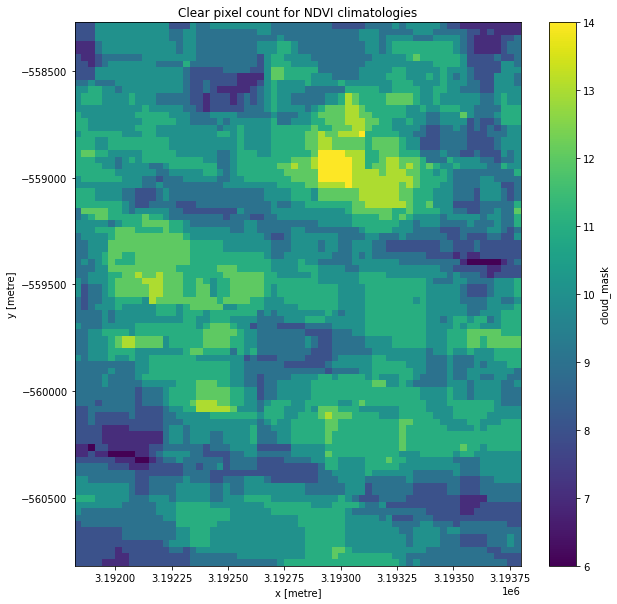

In [9]:
pq_count_ls.plot(figsize=(10,10))

plt.title('Clear pixel count for NDVI climatologies');

In [10]:
# load cloud-masked landsat using load_ard
ds_ls57 = load_ard(dc=dc,
              products=['ls5_sr','ls7_sr'],
              predicate=filter_season,
              mask_filters=(['opening',5], ['dilation',5]),
              dask_chunks=dask_chunks,
              measurements = ['red','nir','pixel_quality'],
              time = ('1985', '2019'),
              **query,
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
Filtering datasets using filter function
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 82 time steps as a dask array


In [11]:
#calculate NDVI
ndvi_ls57 = calculate_indices(ds_ls57, 'NDVI', collection='c2', drop=True)

# multiplying the red band with slope and adding to intercept
slope = 0.964
intercept = -0.007
ndvi_ls57_l8 = (ndvi_ls57['NDVI'] - intercept) / slope

#bring into distributed memory to save loading twice
ndvi_ls57_l8 = ndvi_ls57_l8.persist() 

Dropping bands ['red', 'nir', 'pixel_quality']


In [12]:
# load cloud-masked landsat using load_ard
ds_ls = load_ard(dc=dc,
              products=['ls8_sr'],
              predicate=filter_season,
              mask_filters=(['opening',5], ['dilation',5]),
              dask_chunks=dask_chunks,
              measurements = ['red','nir','pixel_quality'],
              time = ('2013', '2019'),
              **query,
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Filtering datasets using filter function
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 40 time steps as a dask array


In [13]:
#calculate NDVI
ndvi_ls = calculate_indices(ds_ls, 'NDVI', collection='c2', drop=True)
ndvi_ls = ndvi_ls.persist() 

Dropping bands ['red', 'nir', 'pixel_quality']


In [14]:
ndvi_combine = (ndvi_ls.combine_first(ndvi_ls57_l8))

In [15]:
#calculate the climatologies and bring into memory
climatology_mean = ndvi_combine.mean("time").NDVI.compute()
climatology_std = ndvi_combine.std("time").NDVI.compute()

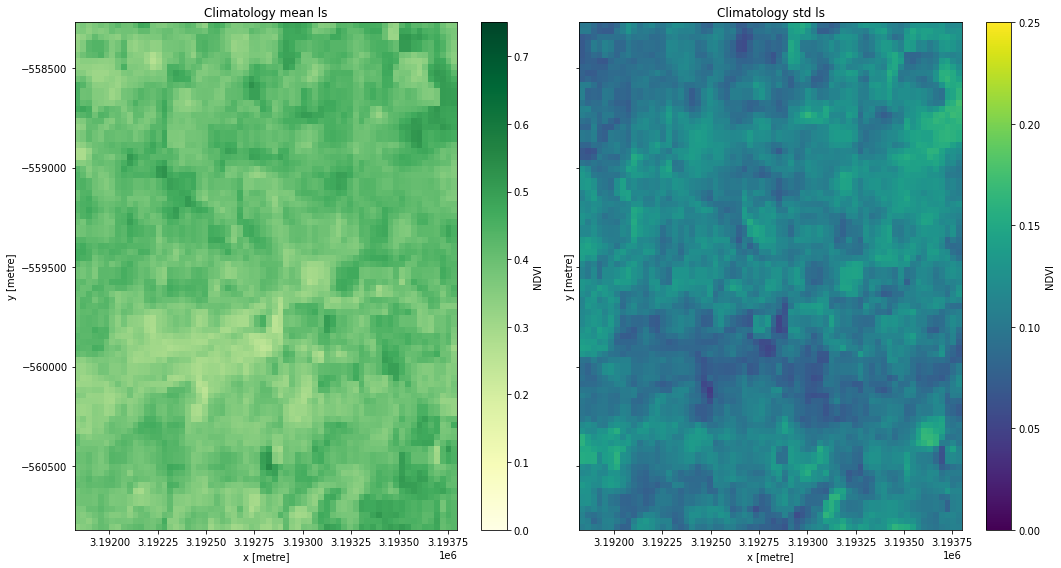

In [18]:
#plot al layers
plt.rcParams['axes.facecolor'] = 'gray' # makes transparent pixels obvious
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(15, 8))

climatology_mean.plot(ax=ax[0], cmap='YlGn' ,vmin=0, vmax=0.75)
ax[0].title.set_text('Climatology mean ls')

climatology_std.plot(ax=ax[1], vmin=0, vmax=0.25)
ax[1].title.set_text('Climatology std ls')

plt.tight_layout()